# ANN Local Fit

Overview:

1. Start with a specific set of kinematic variables.  
2. Initialize a ANN with 4 Kins as input and 3 CFFs as output
3. Pick random starting points for each parameter in ANN
4. Input data to ANN (using current params) to produce Fs
5. Compare resulting Fs to sampled Fs and compute mean squared error
6. Update ANN params in a direction that reduces that mean squared error
7. Repeat steps 3-5 until loss changes only very slightly

The autoreloader enables you to make edits in imported files and those edits will become immediately available.

In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import tensorflow as tf

from BHDVCStf import BHDVCS #modified bhdvcs file
import utilities as uts #general utilities that are useful for all methods

## General global variable definitions

In [56]:
bhdvcs = BHDVCS()
df = pd.read_csv("dvcs_xs_newsets_genCFFs.csv")
data = uts.DvcsData(df)

numSets = 10
numReplicas = 150

## Define and compile model

This makes use of the tensorflow [functional api](https://www.tensorflow.org/guide/keras/functional)

In [57]:
kinematics = tf.keras.Input(shape=(4))
x = tf.keras.layers.Dense(20, activation="tanh")(kinematics)
outputs = tf.keras.layers.Dense(3)(x) #three output nodes for ReH

noncffInputs = tf.keras.Input(shape=(8))
totalUUXSInputs = tf.keras.layers.concatenate([noncffInputs, outputs])
F = uts.TotalUUXSlayer()(totalUUXSInputs) # incorporate cross-sectional function

globalModel = tf.keras.Model(inputs=[kinematics, noncffInputs], outputs=F, name="GlobalModel")

In [58]:
globalModel.compile(
    optimizer = tf.keras.optimizers.Adam(.02),
    loss = tf.keras.losses.MeanSquaredError(),
)

In [59]:
Wsave = globalModel.get_weights()

## Produce CFFdists

In [60]:
print(Wsave[0])

[[-2.19056606e-01  4.86819506e-01 -3.91543031e-01  2.25011945e-01
   3.02250743e-01  4.15110707e-01  4.44607377e-01  3.62591743e-01
  -3.85659933e-02 -3.30186367e-01 -7.44441748e-02 -1.33776665e-03
  -1.76980138e-01  1.07718945e-01  1.09822392e-01 -1.73226714e-01
  -2.34217167e-01 -4.31649089e-01  3.88080001e-01 -3.64370346e-01]
 [ 4.59690094e-01  1.78185463e-01 -4.91125226e-01 -1.81590438e-01
   1.97172165e-04  3.09399366e-02 -1.96607232e-01 -1.22105837e-01
  -1.47310257e-01  3.59198570e-01 -3.35699916e-01  2.22429752e-01
   3.97728562e-01 -9.42821503e-02  5.19217253e-02 -1.38239026e-01
   2.39214182e-01  2.97795892e-01 -2.52941966e-01 -4.70985889e-01]
 [-1.17144942e-01 -8.80941153e-02 -4.08596754e-01 -4.09363627e-01
   3.38034749e-01 -1.02300406e-01 -9.75699425e-02  1.90731049e-01
  -3.49319339e-01 -3.14313054e-01  5.10491133e-02 -1.32973313e-01
  -3.79475236e-01 -4.53175068e-01 -1.81501150e-01  5.42218685e-02
  -3.02804112e-01 -1.08046412e-01 -2.95794010e-02  1.05550766e-01]
 [ 5.82

In [61]:
def produceCFFs(numReplicas, data, Wsave):
    '''
    :param numSamples: number of replicas to produce
    :param data: whole DvcsData
    :param Wsave: saved weights
    
    :returns: numpy array of shape (numSets, numReplicas, 3)
    '''

    by_sample = []

    #for i in tqdm(range(max(data.df['#Set'])+1)):
        
    globalModel.set_weights(Wsave) # reset weights to original value

    setI = data.getSet(1) #DvcsData object containing specific set

    by_set = []

    for sample in tqdm(range(numReplicas)):
        
        #this callback enables us to roll the network back to its minimum loss during training
        chkpt_path = 'networks/best-' + str(sample) + '.hdf5'
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=chkpt_path,
            save_weights_only=True,
            monitor='loss',
            mode='min',
            save_best_only=True)


        globalModel.fit([setI.Kinematics, setI.XnoCFF], setI.sampleY(), # the sample Y will generate Fs
                    epochs=1000, verbose=0,
                    callbacks=[model_checkpoint_callback])

        globalModel.load_weights(chkpt_path) # load back minimum loss epoch

        cffs = uts.cffs_from_globalModel(globalModel, setI.Kinematics, len(globalModel.layers) - 5) # get cffs from middle model

        by_set.append(cffs)

        by_sample.append(by_set)
        
    return np.array(by_sample)

This took about 2 hours to run

In [62]:
results = produceCFFs(numReplicas, data, Wsave)

  0%|          | 0/150 [00:00<?, ?it/s]

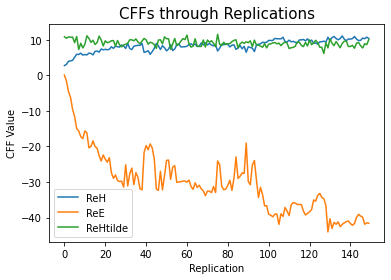

In [69]:
# actualValues: [13.0554, -53.0554, 7.25302]
uts.plot_cff_distribution(results, 0, numReplicas)

In [64]:
#Gets average of ALL predictions of replicas
y_yhat, err = uts.y_yhat_errCFFs(data, results, 0)
print(y_yhat)

#Calculates average after half the replicas 
y_yhat, err = uts.y_yhat_errCFFsNew(data, results, 0, numReplicas)
print(y_yhat)

#First Item
print(results[0][0][0])
#Last Item
print(results[0][-1][0])

[[13.0554     8.4049778]]
[[13.0554      9.40961075]]
2.7792575
10.381831


In [65]:
#Gets average of ALL predictions of replicas
y_yhat, err = uts.y_yhat_errCFFs(data, results, 1)
print(y_yhat)

#Calculates average after half the replicas 
y_yhat, err = uts.y_yhat_errCFFsNew(data, results, 1, numReplicas)
print(y_yhat)

#First Item
print(results[0][0][1])
#Last Item
print(results[0][-1][1])

[[-53.0554     -30.35208702]]
[[-53.0554     -35.81052399]]
0.08846604
-41.589775


In [66]:
#Gets average of ALL predictions of replicas
y_yhat, err = uts.y_yhat_errCFFs(data, results, 2)
print(y_yhat)

#Calculates average after half the replicas 
y_yhat, err = uts.y_yhat_errCFFsNew(data, results, 2, numReplicas)
print(y_yhat)


#First Item
print(results[0][0][2])
#Last Item
print(results[0][-1][2])



[[7.25302   9.1271801]]
[[7.25302    8.83864307]]
10.88672
10.070565
